In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import os
try:
	os.chdir('C:\\Users\\Administrator\\Desktop\\ml_ipynb\\ex2')
	print(os.getcwd())
except:
    print(os.getcwd()+" not changed!!!")
	

C:\Users\Administrator\Desktop\ml_ipynb\ex2


 # ex2  - 逻辑回归

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
sys.path.append('..')
from helper import formulas



# 1 载入数据

In [3]:
path = 'ex2data1.txt'
data = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
data.head()


,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


 让我们创建两个分数的散点图，并使用颜色编码来可视化，
 如果样本是正的（被接纳）或负的（未被接纳）。

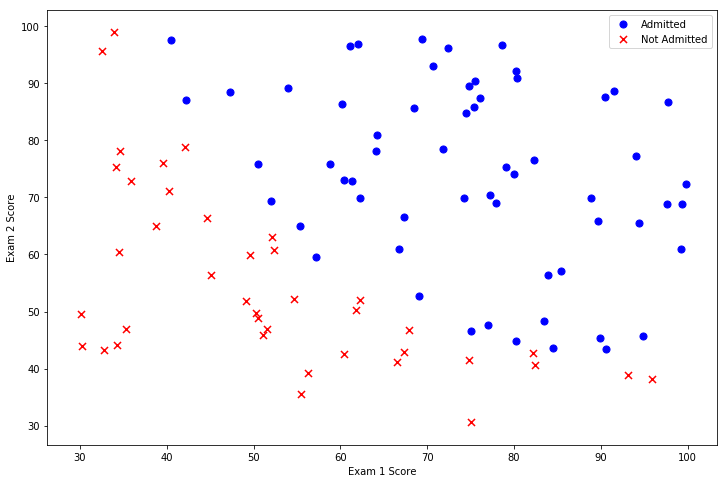

In [4]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Exam 1'], positive['Exam 2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()




 看起来在两类间，有一个清晰的决策边界。现在我们需要实现逻辑回归，
 那样就可以训练一个模型来预测结果。

 测试一下Sigmod函数

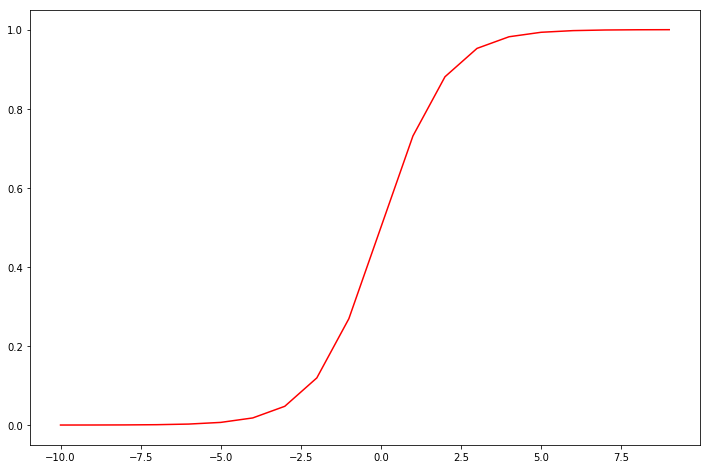

In [5]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(nums, formulas.sigmoid(nums), 'r')
plt.show()



 ## 2 运行算法

In [6]:
# add a ones column - this makes the matrix multiplication work out easier
data.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]



In [7]:
# 开始转换为np对象
X = X.values
y = y.values.ravel()
theta = np.zeros(X.shape[1])
# 打印一下参数维度
X.shape, theta.shape, y.shape


((100, 3), (3,), (100,))

 让我们计算初始化参数的代价函数(theta为0)。

In [8]:
cost = formulas.logisticReg_cost(theta,X, y)
print("cost at theta = [0,0,0] is ",cost)


cost at theta = [0,0,0] is  0.6931471805599452


 注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算一个梯度步长。
 在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

 我们看看用我们的数据和初始参数为0的梯度下降法的结果。

In [9]:
grad = formulas.logisticReg_grad(theta,X, y)
print("grad at theta = [0,0,0] is ",grad)





grad at theta = [0,0,0] is  [ -0.1        -12.00921659 -11.26284221]


 现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [10]:
result = opt.fmin_tnc(func=formulas.logisticReg_cost, x0=theta,
fprime=formulas.logisticReg_grad, args=(X, y))
#看一下结果,返回的是tuple,第一个元素就是最优解
# 第二个元素是当前的尝试了多少次
result




(array([-25.16131863,   0.20623159,   0.20147149]), 36, 0)

 让我们看看在这个结果下代价函数计算结果是什么个样子~

In [11]:
formulas.logisticReg_cost(result[0], X, y)


0.2034977015894746

 接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，
 我们可以使用这个函数来给我们的分类器的训练精度打分。
 逻辑回归模型的假设函数：

In [12]:
def predict(theta, X):
    p = np.zeros(X.shape[0])
    pred = formulas.sigmoid(X @ theta)
    p[np.where(pred>=.5)] = 1
    return p



In [13]:
# 89% 精确度
theta_min = result[0]
pred = predict(theta_min, X)
print('Train accuracy: {}'.format(np.mean(y == pred) * 100))



Train accuracy: 89.0


 # 正则化逻辑回归

 和第一部分很像，从数据可视化开始吧！

In [14]:
path =  'ex2data2.txt'
data = pd.read_csv(path, header=None, names=['Test 1', 'Test 2', 'Accepted'])
data.head()



,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


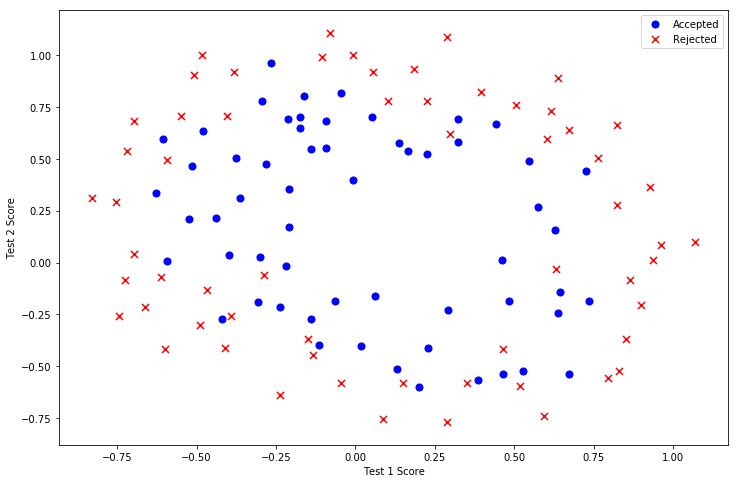

In [15]:
positive = data[data['Accepted'].isin([1])]
negative = data[data['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()


 哇，这个数据看起来可比前一次的复杂得多。特别地，你会注意到其中没有线性决策界限，
 来良好的分开两类数据。一个方法是用像逻辑回归这样的线性技术来构造从原始特征的多
 项式中得到的特征。

In [16]:

[m,n] = data.shape
X = data.iloc[:,0:n-1].values
y = data.iloc[:,n-1:n].values.ravel()
x1 = X[:,0].reshape((m,1))
x2 = X[:,1].reshape((m,1))
#映射参数
X = formulas.mapFeatures(x1,x2,6)
[m,n] = X.shape






 开始运行

In [17]:
lmd=1
initial_theta = np.zeros(n)
result = opt.fmin_tnc(func=formulas.logisticReg_cost_reg, x0=initial_theta, 
    fprime=formulas.logisticReg_grad_reg, args=(X, y, lmd))
theta_min = result[0]
pred = predict(theta_min, X)
#达到83%
print('Train accuracy: {}'.format(np.mean(y == pred) * 100))



Train accuracy: 83.05084745762711


 画边界

D:\programSoftware\Anaconda3\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


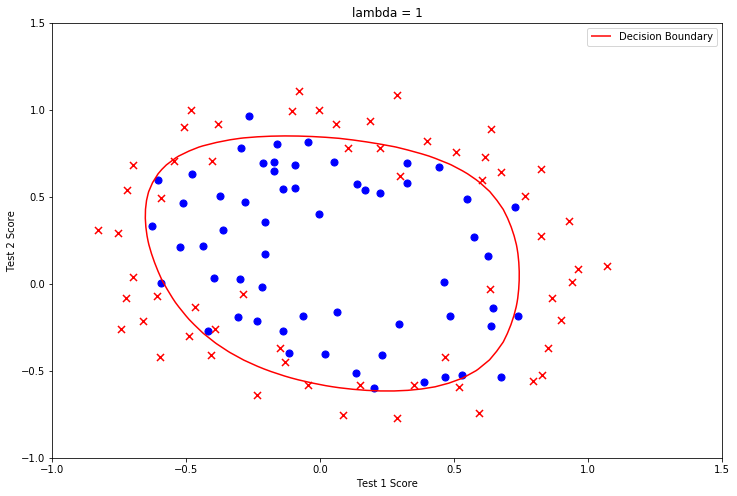

In [18]:



fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.axes.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')


plt.title('lambda = {}'.format(lmd))
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
u2 = u.reshape(50,1)
v2 = v.reshape(50,1)
# 初始化z为这50个值
z = np.zeros((u.size, v.size))
# Evaluate z = theta*x over the grid
for i in range(0, u.size):
    for j in range(0, v.size):
        z[i, j] = np.dot(formulas.mapFeatures(u2[i], v2[j],6), theta_min)
z = z.T
cs = plt.contour(u, v, z, levels=[0], colors='r', label='Decision Boundary')
plt.legend([cs.collections[0]], ['Decision Boundary'])


